<a href="https://colab.research.google.com/github/GabrielFurnielesGarcia/deeplearning-2024/blob/main/Texto/LAB_02_Classify_Text_with_Transformer_Encoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center>
  <font size=7> LAB 02 <font>
  
  <font size=6> Clasificación de texto utilizando Transformers <font>

  01/04/2024

  <p>Sofía Ángel y Gabriel Furnieles</p>
</center>

## Librerías

In [1]:
# Dataset
from keras.datasets import reuters

# TF data
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

# TF y keras
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Dense, Dropout, LayerNormalization, MultiHeadAttention
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow import keras

# Others
import matplotlib.pyplot as plt
import numpy as np

# NLP
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [14]:
# Fijar semillas para reproducibilidad
tf.random.set_seed(42)
np.random.seed(42)

## Dataset

El conjunto de datos utilizado en este laboratorio es el dataset [`reuters`](https://keras.io/api/datasets/reuters/)  


In [2]:
# Cargar los datos
# num_words = 10000 -> El vocabulario solo contiene las 10000 palabras más frecuentes
(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=10000)

# Vocabulario (todas las palabras)
# Aquellas palabras que no estén en el top num_words=10000 aparecerán con el token oov
vocab = reuters.get_word_index()

# Añadir tokens especiales (no están incluidos, ver https://keras.io/api/datasets/reuters/)
vocab['<UNK>'] = -1
vocab['<START>'] = -2
vocab['<PAD>'] = -3

print(f"Train data: {len(train_data)}")
print(f"Test data: {len(test_data)}")
print(f"Vocabulary size (all words): {len(vocab)}")

550378/550378 [==============================] - 0s 0us/step
Train data: 8982
Test data: 2246
Vocabulary size (all words): 30982


In [3]:
# Invertir vocab para decodificar
vocab_inv = dict([(value,key) for (key, value) in vocab.items()])

def decode_text(enc_text:list[int]):
  return ' '.join([vocab_inv.get(i - 3, '?') for i in enc_text])

print("Ejemplo dataset\n-------------------------------------------------")
print(f"Input texto: {decode_text(train_data[0])}")
print(f"Input codificado: {train_data[0]}")
print(f"Etiqueta: {train_labels[0]}")
print("-------------------------------------------------")

Ejemplo dataset
-------------------------------------------------
Input texto: <START> <UNK> <UNK> said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3
Input codificado: [1, 2, 2, 8, 43, 10, 447, 5, 25, 207, 270, 5, 3095, 111, 16, 369, 186, 90, 67, 7, 89, 5, 19, 102, 6, 19, 124, 15, 90, 67, 84, 22, 482, 26, 7, 48, 4, 49, 8, 864, 39, 209, 154, 6, 151, 6, 83, 11, 15, 22, 155, 11, 15, 7, 48, 9, 4579, 1005, 504, 6, 258, 6, 272, 11, 15, 22, 134, 44, 11, 15, 16, 8, 197, 1245, 90, 67, 52, 29, 209, 30, 32, 132, 6, 109, 15, 17, 12]
Etiqueta: 3
-------------------------------------------------


En primer lugar vemos que efectivamente existen palabras fuera de vocabulario en los 2 primeros tokens representadas como `<UNK>`.

Por otro lado vemos que la puntuación ha sido eliminada de las frases, sin embargo no parece que se haya aplicado ninguna técnica de poda de sufijos/prefijos en las palabras (_lemmatization_ ó _stemming_). Además, tampoco se han eliminado palabras muy frecuentes (_stopwords_)

In [50]:
# Proporción de tokens <UNK> en train y test
def unk_tokens(data: np.ndarray[list[int]], unk_idx:int = 2):
  T = 0
  count = 0
  for t in data:
    count += np.sum(np.array(t)==unk_idx)
    T += len(t)

  return count/T*100

print(f'Proporción OOV tokens en train: {unk_tokens(train_data)}')
print(f'Proporción OOV tokens en test: {unk_tokens(test_data)}')

Proporción OOV tokens en train: 2.731176165949761
Proporción OOV tokens en test: 2.76709875258935


Apenas hay diferencia en la proporción de tokens OOV entre train y test por lo que no hay riesgo de baja representabilidad

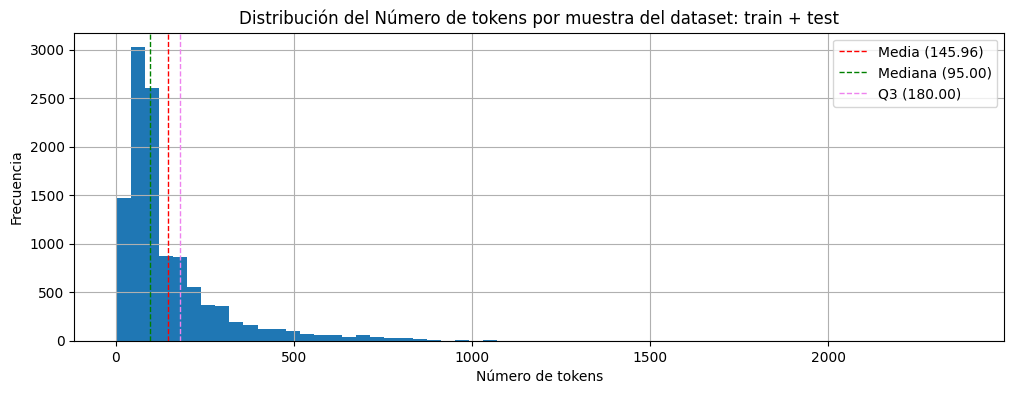

In [4]:
def num_tokens_dist(lengths: np.ndarray[int]):
  plt.figure(figsize=(12, 4))

  # Plot histogram
  plt.hist(lengths, bins=60)
  plt.xlabel('Número de tokens')
  plt.ylabel('Frecuencia')
  plt.title('Distribución del Número de tokens por muestra del dataset: train + test')
  plt.grid(True)

  # Calculate mean
  mean_length = np.mean(lengths)
  plt.axvline(mean_length, color='red', linestyle='dashed', linewidth=1, label=f'Media ({mean_length:.2f})')

  # Calculate median
  median_length = np.median(lengths)
  plt.axvline(median_length, color='green', linestyle='dashed', linewidth=1, label=f'Mediana ({median_length:.2f})')

  # Calculate 3rd quartile
  q3_length = np.percentile(lengths, 75)
  plt.axvline(q3_length, color='violet', linestyle='dashed', linewidth=1, label=f'Q3 ({q3_length:.2f})')

  # Add legend
  plt.legend()

  plt.show()

# Calculate lengths of lists
lengths = np.array([len(x) for x in np.concatenate([train_data, test_data])])
num_tokens_dist(lengths)

Atendiendo a la longitud de los textos vemos como el 50% de estos no supera los 95 tokens (palabras) y el 75% está por debajo de los 180, mientras la media se situa en los ~146 tokens.

Existen unas cuantas muestras que se salen de estos rangos y que son consideradas outliers.

<br>
Es importante tener en cuenta estos números de cara a construir el modelo transformer para determinar el tamaño de la ventana de contexto.

Se crearán dos conjuntos de datos, ambos con 100 tokens de ventana de contexto*:
- Dataset 1: Dataset sin postprocesamiento
- Dataset 2: Resultado de aplicar la eliminación de stopwords


*Después de un análisis de los datos, se puede determinar que la mayoría de las secuencias de texto en el conjunto de datos de Reuters tienen una longitud promedio de alrededor de 100 palabras o menos. Por lo tanto, establecer maxlen en 100 podría ser suficiente para capturar la mayoría de la información relevante en las secuencias.

In [5]:
# Máxima longitud de los textos
MAXLEN = 100

# Dividir los datos en conjuntos de entrenamiento y validación
x_train, x_val, y_train, y_val = train_test_split(train_data, train_labels, test_size=0.1, random_state=42)

# Crear tf.datasets
x_train_padded1 = tf.keras.preprocessing.sequence.pad_sequences(x_train, maxlen=MAXLEN)
x_val_padded1 = tf.keras.preprocessing.sequence.pad_sequences(x_val, maxlen=MAXLEN)
y_train_one_hot1 = tf.one_hot(y_train, depth=46)
y_val_one_hot1 = tf.one_hot(y_val, depth=46)

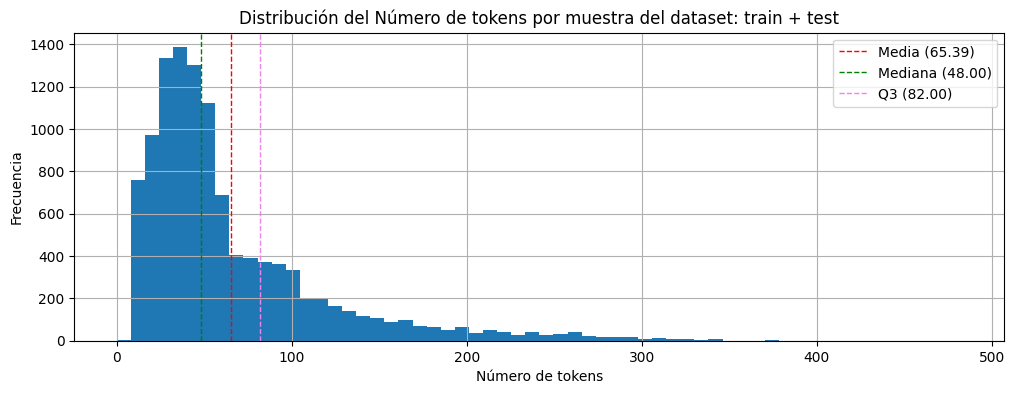

In [6]:
# Eliminar stopwords
stop_words = stopwords.words('english')
stop_words_idx = [vocab.get(w) for w in stop_words]
stop_words_idx = np.array([x for x in stop_words_idx if x is not None])

train_data2 = [np.setdiff1d(lst, stop_words_idx) for lst in train_data]
test_data2 = [np.setdiff1d(lst, stop_words_idx) for lst in test_data]

# Calculate lengths of lists
lengths = np.array([len(x) for x in (train_data2 + test_data2)])
num_tokens_dist(lengths)

Vemos que después de eliminar las _stopwords_ el número de tokens (palabras) por frase se reduce considerablemente. De esta manera es posible añadir más contexto rico en información al modelo

In [7]:
# Dividir los datos en conjuntos de entrenamiento y validación
# Importante utilizar el mismo random_state para que la división sea la misma
x_train2, x_val2, y_train2, y_val2 = train_test_split(train_data2, train_labels, test_size=0.1, random_state=42)

In [8]:
# Crear tf.datasets
# Se añade padding para completar las secuencias con longitud < 100, mientras que las más largas son recortadas
x_train_padded2 = tf.keras.preprocessing.sequence.pad_sequences(x_train2, maxlen=MAXLEN)
x_val_padded2 = tf.keras.preprocessing.sequence.pad_sequences(x_val2, maxlen=MAXLEN)
y_train_one_hot2 = tf.one_hot(y_train2, depth=46)
y_val_one_hot2 = tf.one_hot(y_val2, depth=46)

assert tf.math.reduce_all((y_val_one_hot1 == y_val_one_hot2)).numpy()

## Modelos

Dado que el objetivo del dataset es clasificar textos sin ningún tipo de dependencia temporal o secuencial en cuanto a las predicciones, esto es, para un texto dado el modelo debe predecir una de las 46 clases posibles sin importar las predicciones que haya realizado anteriormente, se utilizará tan solo el bloque **Encoder** de la arquitectura Transformer, no siendo necesario así el módulo Decoder.

In [9]:
# Parámetros fijos
NUM_CLASSES = 46
VOCAB_SIZE = max([max(sequence) for sequence in train_data]) + 1 # <- 10000 de acuerdo al parám. num_words al cargar el dataset

In [10]:
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim)
        self.dense_proj = tf.keras.Sequential([
            layers.Dense(dense_dim, activation="relu"),
            layers.Dense(embed_dim)
        ])
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()

    def call(self, inputs, mask=None):
        if mask is not None:
            mask = mask[:, tf.newaxis, :]
        attention_output = self.attention(
            inputs, inputs, attention_mask=mask)
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)

    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "dense_dim": self.dense_dim,
        })
        return config

In [11]:
# Define la clase PositionalEmbedding
class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, input_dim, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = layers.Embedding(
            input_dim=input_dim, output_dim=output_dim)
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=output_dim)
        self.sequence_length = sequence_length
        self.input_dim = input_dim
        self.output_dim = output_dim

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)

    def get_config(self):
        config = super().get_config()
        config.update({
            "output_dim": self.output_dim,
            "sequence_length": self.sequence_length,
            "input_dim": self.input_dim,
        })
        return config

### Modelo 1

En este primer modelo tan solo se utiliza un bloque TransformerEncoder seguido de una capa densa con el mismo núm. de neuronas que clases. El objetivo de este experimento estudiar el modelo más simple posible y comparar además cuál de los dos datasets (con/sin stopwords) resulta mejor para el entrenamiento

In [12]:
# Parámetros
embedding_dim = 128
num_heads = 8
dropout_rate = 0.2
dense_dim = 64

In [15]:
# Construir el modelo
def create_model1():
  inputs = layers.Input(shape=(MAXLEN,))
  embedding_layer = PositionalEmbedding(MAXLEN, VOCAB_SIZE, embedding_dim)
  x = embedding_layer(inputs)
  transformer_block = TransformerEncoder(embedding_dim, dense_dim, num_heads)
  x = transformer_block(x)
  x = layers.GlobalAveragePooling1D()(x)
  x = layers.Dropout(dropout_rate)(x)
  outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x)

  model = keras.Model(inputs=inputs, outputs=outputs)

  # Compilación del modelo
  model.compile(optimizer="rmsprop", loss="categorical_crossentropy", metrics=["accuracy"])

  return model

# Resumen del modelo
model1 = create_model1()
model1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 100)]             0         
                                                                 
 positional_embedding_1 (Po  (None, 100, 128)          1292800   
 sitionalEmbedding)                                              
                                                                 
 transformer_encoder_1 (Tra  (None, 100, 128)          544576    
 nsformerEncoder)                                                
                                                                 
 global_average_pooling1d_1  (None, 128)               0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                           

In [16]:
# Entrenamiento del modelo1 en el dataset1
history = model1.fit(x_train_padded1, y_train_one_hot1, epochs=20, batch_size=32, validation_data=(x_val_padded1, y_val_one_hot1))

Epoch 1/20
253/253 [==============================] - 19s 53ms/step - loss: 1.5738 - accuracy: 0.6123 - val_loss: 1.3279 - val_accuracy: 0.6863
Epoch 2/20
253/253 [==============================] - 7s 26ms/step - loss: 0.9589 - accuracy: 0.7630 - val_loss: 1.0580 - val_accuracy: 0.7408
Epoch 3/20
253/253 [==============================] - 5s 21ms/step - loss: 0.6938 - accuracy: 0.8247 - val_loss: 1.1116 - val_accuracy: 0.7308
Epoch 4/20
253/253 [==============================] - 5s 20ms/step - loss: 0.5263 - accuracy: 0.8720 - val_loss: 0.9553 - val_accuracy: 0.7909
Epoch 5/20
253/253 [==============================] - 4s 17ms/step - loss: 0.4093 - accuracy: 0.9005 - val_loss: 1.0977 - val_accuracy: 0.7564
Epoch 6/20
253/253 [==============================] - 6s 22ms/step - loss: 0.3308 - accuracy: 0.9183 - val_loss: 1.1106 - val_accuracy: 0.7542
Epoch 7/20
253/253 [==============================] - 4s 18ms/step - loss: 0.2753 - accuracy: 0.9295 - val_loss: 1.2500 - val_accuracy: 0.764

Vemos que el modelo logra una muy buena precisión en el dataset de entrenamiento (~95%) mientras que en el conjunto de test se queda muy por detrás, lo que indica _overfitting_

In [17]:
# Entrenamiento del modelo1 en el dataset2
model1 = create_model1()
history12 = model1.fit(x_train_padded2, y_train_one_hot2, epochs=20, batch_size=32, validation_data=(x_val_padded2, y_val_one_hot2))

Epoch 1/20
253/253 [==============================] - 21s 73ms/step - loss: 1.6034 - accuracy: 0.6077 - val_loss: 1.3621 - val_accuracy: 0.6674
Epoch 2/20
253/253 [==============================] - 13s 50ms/step - loss: 0.9429 - accuracy: 0.7734 - val_loss: 1.0285 - val_accuracy: 0.7631
Epoch 3/20
253/253 [==============================] - 11s 43ms/step - loss: 0.6531 - accuracy: 0.8435 - val_loss: 0.9940 - val_accuracy: 0.7675
Epoch 4/20
253/253 [==============================] - 9s 36ms/step - loss: 0.4894 - accuracy: 0.8807 - val_loss: 1.0129 - val_accuracy: 0.7753
Epoch 5/20
253/253 [==============================] - 7s 28ms/step - loss: 0.3794 - accuracy: 0.9084 - val_loss: 0.9576 - val_accuracy: 0.7909
Epoch 6/20
253/253 [==============================] - 8s 30ms/step - loss: 0.3167 - accuracy: 0.9256 - val_loss: 0.9628 - val_accuracy: 0.7909
Epoch 7/20
253/253 [==============================] - 4s 18ms/step - loss: 0.2744 - accuracy: 0.9353 - val_loss: 1.0532 - val_accuracy: 0.7

Utilizando el segundo conjunto de entrenamiento (después de eliminar stopwords) el modelo logra aumentar su precisión en test en torno a 2 décimas, tomando como referencia las media de las diferencias entre una iteración y la otra, por lo que podemos concluir que **el segundo dataset es más apto para el objetivo de la práctica.**

El principal motivo de que el 2º dataset produzca mejores resultados es que, al eliminar las palabras más frecuentes del idioma (inglés), eliminamos así también el ruido que estas contienen pues en la mayoría de casos no añaden información relevante, facilitando así la tarea del modelo. Esto se ve reflejado en una mejora sustancial en el conjunto de test, al poder el modelo generalizar mejor a otros casos pues no ha sido sobreajustado con el ruido del dataset de entrenamiento.

### Modelo 2

Pese a contar con tan solo 1 bloque Encoder el modelo1 ha logrado obtener resultados notablemente positivos, llegando incluso a sobreajustar el dataset de entrenamiento. En este modelo 2 se analiza el efecto de concatenar un segundo bloque Encoder.

Para reducir el _overfitting_ se aumenta el ratio de dropout y se prueba a utilizar el optimizar _adam_. Además se aplica el método de regularización __label smoothing__* y se aumenta el tamaño del batch.

<br>
* label smoothing es una técnica de regularización en la que, en lugar de asignar una etiqueta "hard" de 0 o 1 a la clase verdadera, se utiliza una distribución de etiquetas suavizada, normalmente con valores ligeramente inferiores a 1 para la clase verdadera y un pequeño valor positivo para otras clases.

$$
\text{Dado } \epsilon <\!\!< 1 \\
0: \rightarrow 0 + \epsilon \\
1: \rightarrow 1 - \epsilon
$$

Esto evita que el modelo se confíe demasiado y le anima a aprender características más robustas, mejorando el rendimiento de la generalización.

In [18]:
# Parámetros
embedding_dim = 128
num_heads = 8
dropout_rate = 0.4
dense_dim = 64

In [19]:
# Construir el modelo
def create_model2():
  inputs = layers.Input(shape=(MAXLEN,))
  embedding_layer = PositionalEmbedding(MAXLEN, VOCAB_SIZE, embedding_dim)
  x = embedding_layer(inputs)
  transformer_block = TransformerEncoder(embedding_dim, dense_dim, num_heads)
  x = transformer_block(x)
  transformer_block2 = TransformerEncoder(embedding_dim, dense_dim, num_heads)
  x = transformer_block2(x)
  x = layers.GlobalAveragePooling1D()(x)
  x = layers.Dropout(dropout_rate)(x)
  outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x)

  model2 = keras.Model(inputs=inputs, outputs=outputs)

  # Compilación del modelo
  model2.compile(optimizer="adam", loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1), metrics=["accuracy"])
  return model2

# Resumen del modelo
model2 = create_model2()
model2.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 100)]             0         
                                                                 
 positional_embedding_3 (Po  (None, 100, 128)          1292800   
 sitionalEmbedding)                                              
                                                                 
 transformer_encoder_3 (Tra  (None, 100, 128)          544576    
 nsformerEncoder)                                                
                                                                 
 transformer_encoder_4 (Tra  (None, 100, 128)          544576    
 nsformerEncoder)                                                
                                                                 
 global_average_pooling1d_3  (None, 128)               0         
  (GlobalAveragePooling1D)                                 

In [20]:
# Entrenamiento del modelo2 en el dataset2
history_2 = model2.fit(x_train_padded2, y_train_one_hot2, epochs=20, batch_size=80, validation_data=(x_val_padded2, y_val_one_hot2))

Epoch 1/20
102/102 [==============================] - 22s 139ms/step - loss: 2.1313 - accuracy: 0.5872 - val_loss: 1.6725 - val_accuracy: 0.7186
Epoch 2/20
102/102 [==============================] - 12s 116ms/step - loss: 1.4345 - accuracy: 0.7987 - val_loss: 1.3901 - val_accuracy: 0.7909
Epoch 3/20
102/102 [==============================] - 10s 99ms/step - loss: 1.1735 - accuracy: 0.8726 - val_loss: 1.3509 - val_accuracy: 0.8098
Epoch 4/20
102/102 [==============================] - 10s 95ms/step - loss: 1.0082 - accuracy: 0.9232 - val_loss: 1.3819 - val_accuracy: 0.8098
Epoch 5/20
102/102 [==============================] - 10s 94ms/step - loss: 0.9438 - accuracy: 0.9417 - val_loss: 1.3782 - val_accuracy: 0.8142
Epoch 6/20
102/102 [==============================] - 9s 84ms/step - loss: 0.9007 - accuracy: 0.9493 - val_loss: 1.3961 - val_accuracy: 0.8076
Epoch 7/20
102/102 [==============================] - 9s 92ms/step - loss: 0.8841 - accuracy: 0.9535 - val_loss: 1.4275 - val_accuracy:

Añadiendo una capa Encoder y aplicando las medidas de regularización el modelo parece converger de manera más robusta con una precisión de test de ~0.80 (en el anterior modelo la precisisón en el conjunto de test oscilaba entre varios valores mientras en este caso se mantiene en casi todo momento en 0.8)

### Modelo 3

Para el tercer modelo en lugar de combinar dos bloques transformers se prueba a combinar el primero con una LSTM, ya que como bien se ha visto en clase es posible lograr resultados muy buenos con este tipo de modelo.

In [22]:
# Parámetros
embedding_dim = 128
num_heads = 8
dropout_rate = 0.4
dense_dim = 64
lstm_dim = 64

In [23]:
# Construir el modelo
def create_model3():
  inputs = layers.Input(shape=(MAXLEN,))
  embedding_layer = PositionalEmbedding(MAXLEN, VOCAB_SIZE, embedding_dim)
  x = embedding_layer(inputs)
  transformer_block = TransformerEncoder(embedding_dim, dense_dim, num_heads)
  x = transformer_block(x)

  # Add additional layers
  x = layers.LSTM(lstm_dim)(x)  # Add an LSTM layer
  outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x)

  model3 = keras.Model(inputs=inputs, outputs=outputs)

  # Compilación del modelo
  model3.compile(optimizer="adam", loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1), metrics=["accuracy"])
  return model3

# Resumen del modelo
model3= create_model3()
model3.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 100)]             0         
                                                                 
 positional_embedding_4 (Po  (None, 100, 128)          1292800   
 sitionalEmbedding)                                              
                                                                 
 transformer_encoder_5 (Tra  (None, 100, 128)          544576    
 nsformerEncoder)                                                
                                                                 
 lstm (LSTM)                 (None, 64)                49408     
                                                                 
 dense_16 (Dense)            (None, 46)                2990      
                                                                 
Total params: 1889774 (7.21 MB)
Trainable params: 1889774 (

In [24]:
# Entrenamiento del modelo3 en el dataset2
history_3 = model3.fit(x_train_padded2, y_train_one_hot2, epochs=20, batch_size=80, validation_data=(x_val_padded2, y_val_one_hot2))

Epoch 1/20
102/102 [==============================] - 18s 124ms/step - loss: 2.2763 - accuracy: 0.5283 - val_loss: 2.0332 - val_accuracy: 0.5884
Epoch 2/20
102/102 [==============================] - 10s 102ms/step - loss: 1.6722 - accuracy: 0.7161 - val_loss: 1.6358 - val_accuracy: 0.7264
Epoch 3/20
102/102 [==============================] - 12s 118ms/step - loss: 1.2395 - accuracy: 0.8503 - val_loss: 1.4667 - val_accuracy: 0.7786
Epoch 4/20
102/102 [==============================] - 10s 103ms/step - loss: 0.9860 - accuracy: 0.9277 - val_loss: 1.4586 - val_accuracy: 0.7775
Epoch 5/20
102/102 [==============================] - 11s 111ms/step - loss: 0.8860 - accuracy: 0.9479 - val_loss: 1.4600 - val_accuracy: 0.7887
Epoch 6/20
102/102 [==============================] - 9s 92ms/step - loss: 0.8320 - accuracy: 0.9548 - val_loss: 1.4632 - val_accuracy: 0.7842
Epoch 7/20
102/102 [==============================] - 7s 68ms/step - loss: 0.8070 - accuracy: 0.9573 - val_loss: 1.5102 - val_accura

Tras realizar diversas pruebas donde se aumentan o disminuyen las neuronas de la capa LSTM e incluso se añaden más capas densas intermedias con distinto número de neuronas se llega a que el mejor modelo utilizando una capa LSTM es con 64 neuronas y ninguna capa intermedia más. Sin embargo este no alcanza a superar al modelo 2

### Modelo 4

Para este último modelo se prueba a añadir varias capas densas tras la capa transformer. Por otro lado, se varían algunos hiperparámetros como disminur el número de cabezas o número del tamaño del vector de embedding.

In [34]:
# Parámetros
embedding_dim = 256
num_heads = 6
dropout_rate = 0.4
dense_dim = 64
dense_dim1 = 128
dense_dim2 = 64

In [35]:
# Construir el modelo
def create_model4():
  inputs = layers.Input(shape=(MAXLEN,))
  embedding_layer = PositionalEmbedding(MAXLEN, VOCAB_SIZE, embedding_dim)
  x = embedding_layer(inputs)
  transformer_block = TransformerEncoder(embedding_dim, dense_dim, num_heads)
  x = transformer_block(x)
  # transformer_block2 = TransformerEncoder(embedding_dim, dense_dim, num_heads)
  # x = transformer_block2(x)
  x = layers.GlobalMaxPooling1D()(x)
  x = layers.Dropout(dropout_rate)(x)
  x = layers.Dense(dense_dim1, activation='relu')(x) # Añadimos una capa densa
  x = layers.Dense(dense_dim2, activation='relu')(x) # Añadimos una capa densa
  outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x)

  model4 = keras.Model(inputs=inputs, outputs=outputs)

  # Compilación del modelo
  model4.compile(optimizer="adam", loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1), metrics=["accuracy"])
  return model4

# Resumen del modelo
model4 = create_model4()
model4.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 100)]             0         
                                                                 
 positional_embedding_8 (Po  (None, 100, 256)          2585600   
 sitionalEmbedding)                                              
                                                                 
 transformer_encoder_9 (Tra  (None, 100, 256)          1611840   
 nsformerEncoder)                                                
                                                                 
 global_max_pooling1d_3 (Gl  (None, 256)               0         
 obalMaxPooling1D)                                               
                                                                 
 dropout_7 (Dropout)         (None, 256)               0         
                                                           

In [36]:
# Entrenamiento del modelo4 en el dataset2
history_4 = model4.fit(x_train_padded2, y_train_one_hot2, epochs=20, batch_size=128, validation_data=(x_val_padded2, y_val_one_hot2))

Epoch 1/20
64/64 [==============================] - 15s 175ms/step - loss: 2.5515 - accuracy: 0.4371 - val_loss: 2.1054 - val_accuracy: 0.5706
Epoch 2/20
64/64 [==============================] - 8s 127ms/step - loss: 1.9537 - accuracy: 0.6269 - val_loss: 1.8222 - val_accuracy: 0.6630
Epoch 3/20
64/64 [==============================] - 7s 116ms/step - loss: 1.6783 - accuracy: 0.7070 - val_loss: 1.7293 - val_accuracy: 0.6752
Epoch 4/20
64/64 [==============================] - 8s 125ms/step - loss: 1.4944 - accuracy: 0.7596 - val_loss: 1.6289 - val_accuracy: 0.7130
Epoch 5/20
64/64 [==============================] - 7s 106ms/step - loss: 1.3425 - accuracy: 0.8123 - val_loss: 1.5842 - val_accuracy: 0.7453
Epoch 6/20
64/64 [==============================] - 7s 116ms/step - loss: 1.2027 - accuracy: 0.8607 - val_loss: 1.5854 - val_accuracy: 0.7475
Epoch 7/20
64/64 [==============================] - 7s 114ms/step - loss: 1.1057 - accuracy: 0.8898 - val_loss: 1.5913 - val_accuracy: 0.7697
Epoch

A la vista de los resultados obtenidos no parece que aumentar el número de capas densas y modificar el resto de parámetros del bloque transformer añada ninguna mejora

## Resultados

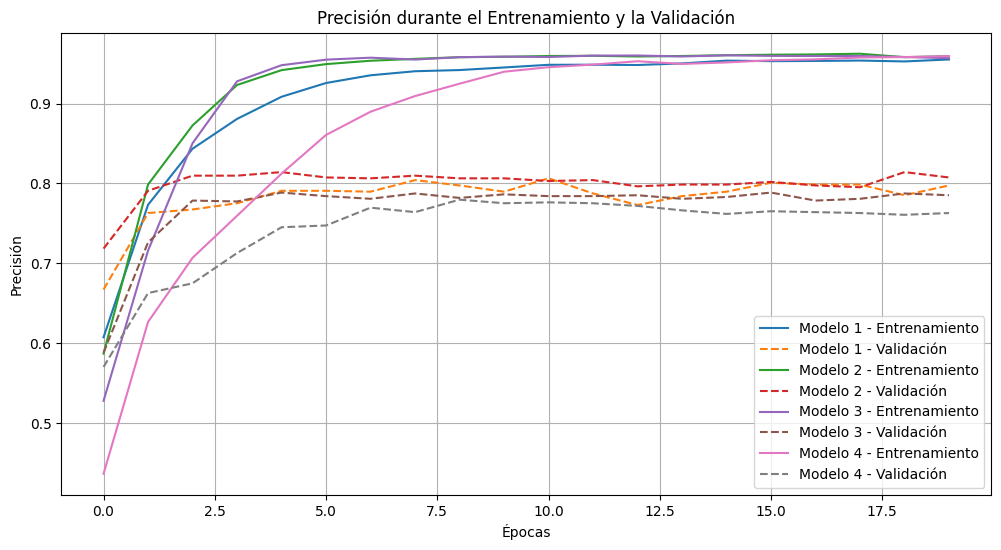

In [37]:
# Precisión durante el entrenamiento y la validación
plt.figure(figsize=(12, 6))
plt.plot(history12.history['accuracy'], label='Modelo 1 - Entrenamiento', linestyle='-')
plt.plot(history12.history['val_accuracy'], label='Modelo 1 - Validación', linestyle='--')

plt.plot(history_2.history['accuracy'], label='Modelo 2 - Entrenamiento', linestyle='-')
plt.plot(history_2.history['val_accuracy'], label='Modelo 2 - Validación', linestyle='--')

plt.plot(history_3.history['accuracy'], label='Modelo 3 - Entrenamiento', linestyle='-')
plt.plot(history_3.history['val_accuracy'], label='Modelo 3 - Validación', linestyle='--')

plt.plot(history_4.history['accuracy'], label='Modelo 4 - Entrenamiento', linestyle='-')
plt.plot(history_4.history['val_accuracy'], label='Modelo 4 - Validación', linestyle='--')

plt.title('Precisión durante el Entrenamiento y la Validación')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()
plt.grid(True)
plt.show()

Mientras todos los modelos parecen converger a la misma precisión de entrenamiento en torno a ~95% es en el dataset de validación donde estos se diferencian.

Mientras el mejor modelo que más rápido converge en train y que logra una precisión más estable a lo largo de las diferentes épocas en el conjunto de test es el `Modelo 2`, los peores resultados los encontramos con la arquitectura del último `Modelo 4`

## Conclusiones

En este Laboratorio 2 se han estudiado 4 arquitecturas diferentes de modelos de texto basados en la conocida arquitectura transformer. Todos ellos han demostrado grandes capacidades a la hora de ajustarse a los datos de entrenamiento rápidamente en apenas unas pocas épocas. Sin embargo, el principal problema común a todos ellos y sobre el que se ha dedicado gran parte del trabajo de la práctica ha sido el sobreajuste o _overfitting_, siendo la arquitectura del `Modelo 2` con dos bloques TransformerEncoder la que mejores capacidades de generalización ha demostrado.

Por otro lado también se ha experimentado con el procesmaiento de los datos, eliminando aquellas palabras más frecuentes de idioma inglés (stopwords) En los experimentos del Modelo 1 se ha observado que el dataset sin stopwords ofrecía más facilidades al modelo a la hora de generalizar correctamente.

A la vista de los experimentos realizados no parece que cambios en la arquitectura del modelo pueda ofrecer mayores capacidades de generalización y proponemos los siguientes cambios que podrían realizarse en el conjunto de datos para mejorar el rendimiento del modelo:

- Incluir todas las palabras posibles como tokens del modelo en lugar de limitarlo a las 10000 más frecuentes (o al menos aumentar este límite)

- Aplicar técnicas de poda (_lemmatization_ o _stemming_) para reducir el ruido entre palabras similares con la misma raíz